# ENEL 645 Recurrent Neural Network (RNN) Tutorial

This tutorial will demonstrate the functioning of RNNs using PyTorch working with time series data to <br>
predict future event outcomes through Calgary Flames vs. Edmonton Oilers Hockey Game Data.

In [1]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1. Exploratory Data Analysis

Let's first take a look at our data. NHL scores from games between Calgary and Edmonton for the last 10 years have been aggregated into a .csv file. <br>
Within this dataset, we have access to the game's date, who the home team was, the overall game score, and the score breakdown by period. <br>
Below is an example summary of a single data point. Our objective will be to use different features of this data to predict who will win the next game!

In [2]:
# Exploratory Data Analysis
# data import
df = pd.read_csv(f'CGY_vs_EDM.csv')
df = df.iloc[::-1]

# visualize single sample
print(f'Oldest game in records:')
print(df.iloc[-1])

# determine total number of games
home_team = np.array(df['Home Team'])
all_CGY_scores = np.array(df['Calgary Score'])
all_EDM_scores = np.array(df['Edmonton Score'])
all_dates = []
for ii in range(df.shape[0]):
    all_dates.append(int(df.iloc[ii]['Date'].replace("/", "")))
all_dates = np.array(all_dates)
print(f'\nTotal Number of Games in records: {all_CGY_scores.shape[0]}.')

# determine max sequence length for per season analysis
lowest_num_games = 100
for date in range(2017, 2024+1):
    date_mask24 = df['Date'].str.contains(f'{date}', case=False, na=False)

    if df[date_mask24].shape[0] < lowest_num_games:
        lowest_num_games = df[date_mask24].shape[0]

seasons = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
NumSeasons = len(seasons)
NumGames = lowest_num_games
dates = np.zeros(shape=(NumSeasons, NumGames))
CGY_scores = np.zeros(shape=(NumSeasons, NumGames))
EDM_scores = np.zeros(shape=(NumSeasons, NumGames))

for ss in range(NumSeasons):
    date_mask = df['Date'].str.contains(f'{seasons[ss]}', case=False, na=False)
    temp_list = df[date_mask]
    for gg in range(NumGames):
        dates[ss, gg] = int(temp_list.iloc[gg]['Date'].replace("/", ""))
        CGY_scores [ss, gg] = temp_list.iloc[gg]['Edmonton Score']
        EDM_scores [ss, gg] = temp_list.iloc[gg]['Calgary Score']

print(f'Number of Seasons (samples): {CGY_scores.shape[0]}.')
print(f'Number of Games (length of each series): {CGY_scores.shape[1]}.')

Oldest game in records:
Date                11/03/2024
Edmonton Score               4
Calgary Score                2
Home Team                  CGY
1st Period - EDM             2
2nd Period - EDM             0
3rd Period - EDM             2
1st Period - CGY             0
2nd Period - CGY             1
3rd Period - CGY             1
Name: 0, dtype: object

Total Number of Games in records: 61.
Number of Seasons (samples): 10.
Number of Games (length of each series): 3.


<details>
 <summary>  What features that are not already present may also help predict game scores?</summary>
  
  1. Total Goals For/Against
  2. Player Trades / How close team is to salary cap
  3. When was the team's last game
</details>

Next, let's visualize the distribution of the data.

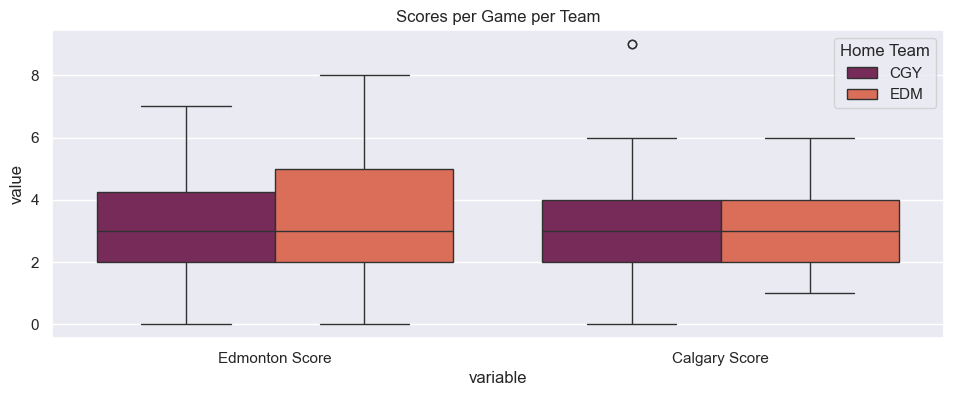

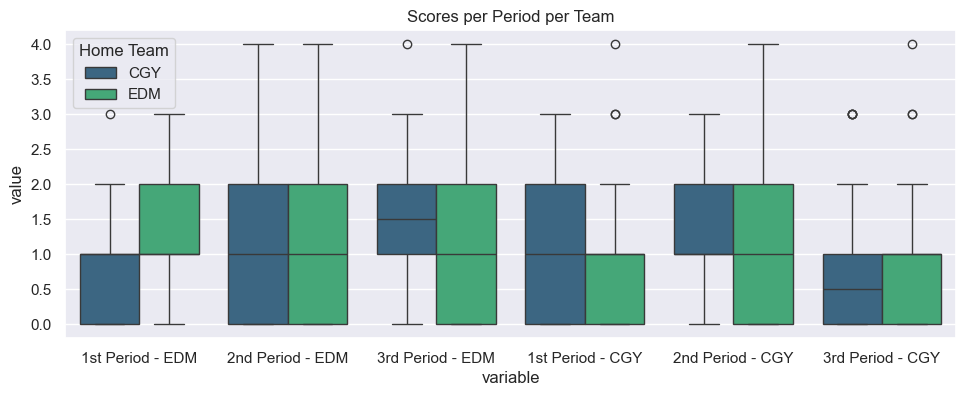

In [3]:
# Visualizing different feature distributions of the data
game_scores = ['Edmonton Score','Calgary Score']
sns.set_theme(rc={'figure.figsize':(11.5,4)})
sns.boxplot(data=df.melt(id_vars='Home Team', value_vars=game_scores), 
            x='variable', y='value', hue='Home Team', palette='rocket').set_title("Scores per Game per Team")
plt.show()

per_scores = ['1st Period - EDM', '2nd Period - EDM', '3rd Period - EDM', '1st Period - CGY', '2nd Period - CGY', '3rd Period - CGY']
sns.set_theme(rc={'figure.figsize':(11.5,4)})
sns.boxplot(data=df.melt(id_vars='Home Team', value_vars=per_scores), 
            x='variable', y='value', hue='Home Team', palette='viridis').set_title("Scores per Period per Team")
plt.show()

The data shows the expected distribution, and no missing values are present. Let's move on to defining and training our model. <br>
While practically, a development set (training and validation) and test set should be used to assess model performance, <br>
due to low data availability and the context of a tutorial on RNNs, only a training set has been generated from the <br>
available data for the experiments below.

### 2. Simple RNN Model Design

Let's start by looking at our time series data through the lens of a simple recurrent neural network.<br> 
We'll first explore the predictive capability of our model when using the date to predict Calgary's score.

#### 2A. Date to Calgary Score (one-to-one example)

Let's take a look at a sample data point for this example.

In [4]:
# Configuring one-to-one data
input_val = torch.tensor(all_dates[:, np.newaxis, np.newaxis], dtype=torch.float32)
output_val = torch.tensor(all_CGY_scores[:, np.newaxis, np.newaxis], dtype=torch.float32)

print(f'One Date/Game Example')
print(f'Date: {input_val[1:2, 0]}')
print(f'Calgary Score: {output_val[1:2, 0]}')

# model params
input_size = input_val.shape[1]
hidden_sizes = [15, 20, 25]
output_size = output_val.shape[1]
total_epochs = 150

print(f'\nModel params:\n - Batch Size: {input_val.shape[0]},\n - Input Features Size: {input_size},\n - Input Sequence Size: {input_val.shape[2]},')
print(f' - Number of Hidden Features to Try: {hidden_sizes},\n - Output Features Size: {output_size},\n - Output Sequence Size: {output_val.shape[2]}')

One Date/Game Example
Date: tensor([[9212015.]])
Calgary Score: tensor([[2.]])

Model params:
 - Batch Size: 61,
 - Input Features Size: 1,
 - Input Sequence Size: 1,
 - Number of Hidden Features to Try: [15, 20, 25],
 - Output Features Size: 1,
 - Output Sequence Size: 1


Before taking a look at the model's base implementation, let's look at the PyTorch nn.RNN layer definition: [PyTorch RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

<details>
  <summary>What are the parameters of a PyTorch nn.RNN layer?</summary>

  - Beyond the data...
     * Number of layers (default is 1)
     * Non-linearity (is limited to tanh and relu) 
     * Bias (default is true but could not have bias if false)
     * Batch_first (deault is false, but this has to do with how you organize your data)
     * Bidirectional (default is false, if true, it allows you to capture future and past context and dependencies)
</details>

In [5]:
# Single Layer Model Definition
class RNN_SL_OtO_Torch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_SL_OtO_Torch, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_val):
        h0 = torch.zeros(1, input_val.size(0), hidden_size).to(input_val.device)
        out, _ = self.rnn(input_val, h0)
        out = self.fc(out)
        return out

lossFnc = nn.MSELoss()

<details>
  <summary>What would the RNN configuration look like if it had more than 1 layer?</summary>
  
  - Depends on whether it is being done sequentially or within the parameters of the nn.RNN definition
     * As per PyTorch's definition: "stacking two RNNs together to form a stacked RNN, with the second 
       RNN taking in outputs of the first RNN and computing the final results"
</details>

In [6]:
# Two Layer Model Definition
class RNN_DL_OtO_Torch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN_DL_OtO_Torch, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, nonlinearity='tanh', batch_first=True)
        self.rnn_2nd = nn.RNN(hidden_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_val):
        h0 = torch.zeros(self.num_layers, input_val.size(0), hidden_size).to(input_val.device)
        out, hidden = self.rnn(input_val, h0)
        out, hidden = self.rnn_2nd(out, hidden)
        out = self.fc(out)
        return out

# class RNN_DL_OtO_Torch(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=1):
#         super(RNN_DL_OtO_Torch, self).__init__()
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers=2, nonlinearity='tanh', batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, input_val):
#         h0 = torch.zeros(2, input_val.size(0), hidden_size).to(input_val.device)
#         out, hidden = self.rnn(input_val, h0)
#         out = self.fc(out)
#         return out

<details>
  <summary>What information needs to be passed to the RNN model in via the data?</summary>

  - Generally you need to pass the following:
     * Input size (Defines how many input features are being passed to the model)
     * Hidden size (Defines how many features are part of the hidden state)
     * Output size (Defines how many output features there will be)
     * Number of layers in the RNN
  - The hidden size and number of layers can be hardcoded depending on the flexibility you want to give to each execution
</details>

In [7]:
# One-to-One Training loop
all_SL_OtO_losses, all_DL_OtO_losses = [], []
SL_OtO_num_params, DL_OtO_num_params  = [], []

for hidden_size in hidden_sizes:
    print(f'For hidden size {hidden_size}', end='\t')
    RNN_SL_OtO_model = RNN_SL_OtO_Torch(input_size, hidden_size, output_size)
    RNN_SL_OtO_train_losses = []
    RNN_SL_OtO_optim = optim.Adam(RNN_SL_OtO_model.parameters(), lr=0.001)
    SL_OtO_num_params.append(sum(p.numel() for p in RNN_SL_OtO_model.parameters() if p.requires_grad))
    print(f'RNN_SL_OtO_Model #trainable parameters: {SL_OtO_num_params[-1]}', end=', ')

    RNN_DL_OtO_model = RNN_DL_OtO_Torch(input_size, hidden_size, output_size)
    RNN_DL_OtO_train_losses = []
    RNN_DL_OtO_optim = optim.Adam(RNN_DL_OtO_model.parameters(), lr=0.001)
    DL_OtO_num_params.append(sum(p.numel() for p in RNN_DL_OtO_model.parameters() if p.requires_grad))
    print(f'RNN_DL_OtO_Model #trainable parameters: {DL_OtO_num_params[-1]}')

    for epoch_num in range(total_epochs):
        # Training
        # Single layer
        RNN_SL_OtO_model.train()
        pred_val_SL_OtO = RNN_SL_OtO_model(input_val)
        RNN_SL_OtO_curr_loss = lossFnc(pred_val_SL_OtO, output_val)

        RNN_SL_OtO_optim.zero_grad()
        RNN_SL_OtO_curr_loss.backward()
        RNN_SL_OtO_optim.step()

        # Two layer
        RNN_DL_OtO_model.train()
        pred_val_DL_OtO = RNN_DL_OtO_model(input_val)
        RNN_DL_OtO_curr_loss = lossFnc(pred_val_DL_OtO, output_val)

        RNN_DL_OtO_optim.zero_grad()
        RNN_DL_OtO_curr_loss.backward()
        RNN_DL_OtO_optim.step()
        
        if (epoch_num + 1) % 10 == 0:
            RNN_SL_OtO_train_losses.append(round(RNN_SL_OtO_curr_loss.item(), 4))
            RNN_DL_OtO_train_losses.append(round(RNN_DL_OtO_curr_loss.item(), 4))

            print(f'For epoch {epoch_num+1} of {total_epochs}, RNN_SL_OtO Train loss: {round(RNN_SL_OtO_curr_loss.item(),4)}', end=', ')
            print(f'RNN_DL_OtO Train loss: {round(RNN_DL_OtO_curr_loss.item(),4)}')

    all_SL_OtO_losses.append(RNN_SL_OtO_train_losses)
    all_DL_OtO_losses.append(RNN_DL_OtO_train_losses)


For hidden size 15	RNN_SL_OtO_Model #trainable parameters: 286, RNN_DL_OtO_Model #trainable parameters: 766
For epoch 10 of 150, RNN_SL_OtO Train loss: 10.7446, RNN_DL_OtO Train loss: 11.5619
For epoch 20 of 150, RNN_SL_OtO Train loss: 9.9146, RNN_DL_OtO Train loss: 9.2045
For epoch 30 of 150, RNN_SL_OtO Train loss: 9.1486, RNN_DL_OtO Train loss: 7.5555
For epoch 40 of 150, RNN_SL_OtO Train loss: 8.4486, RNN_DL_OtO Train loss: 6.4042
For epoch 50 of 150, RNN_SL_OtO Train loss: 7.8141, RNN_DL_OtO Train loss: 5.573
For epoch 60 of 150, RNN_SL_OtO Train loss: 7.2424, RNN_DL_OtO Train loss: 4.9736
For epoch 70 of 150, RNN_SL_OtO Train loss: 6.7303, RNN_DL_OtO Train loss: 4.5501
For epoch 80 of 150, RNN_SL_OtO Train loss: 6.2739, RNN_DL_OtO Train loss: 4.2485
For epoch 90 of 150, RNN_SL_OtO Train loss: 5.8691, RNN_DL_OtO Train loss: 4.0273
For epoch 100 of 150, RNN_SL_OtO Train loss: 5.5119, RNN_DL_OtO Train loss: 3.8614
For epoch 110 of 150, RNN_SL_OtO Train loss: 5.1985, RNN_DL_OtO Train 

<details>
  <summary>What does the one-to-one data configuration look like?</summary>

  - The input is of shape [BatchSize, SequenceLength, InputSize(NumberOfFeatures)]
     * For this example, this equates to [61 samples (61 dates), 1 element in sequence (single date), 1 feature (the date)]
  - The output has similar characteristics [1 element in sequence (single game score), 1 feature (the actual score)]
</details>

Looking at some of our training results, our model's performance is mediocre. This is expected with so few data points and trainable parameters and <br> given the context of the problem (using the date to predict the score).

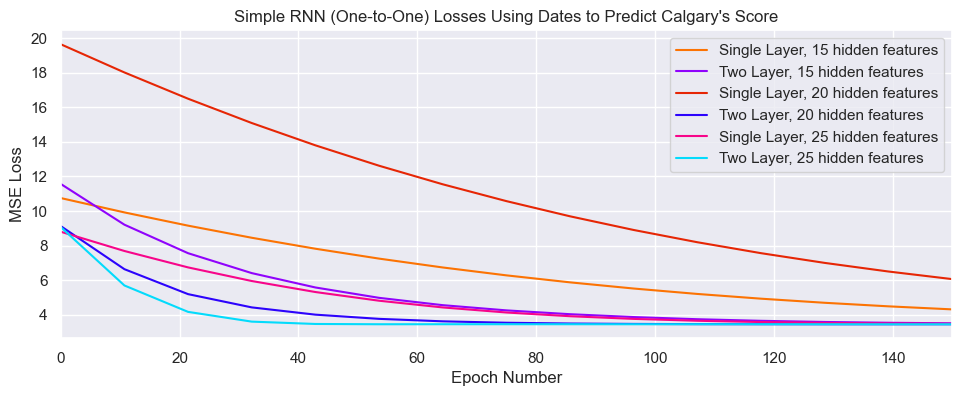

In [8]:
# Plotting Training Losses Across Different Number of Layers and Hidden Features
graph_epochs = np.linspace(0, total_epochs, (total_epochs//10), endpoint=True)
red_shades = ['#fc7303', '#e62605', '#f7058a']
blue_shades = ['#9003fc', '#2c03fc', '#03dbfc']

fig_RNN_losses, ax_RNN_losses = plt.subplots(1)
ax_RNN_losses.set_title("Simple RNN (One-to-One) Losses Using Dates to Predict Calgary's Score")
for ii in range(0, len(hidden_sizes)):
    ax_RNN_losses.plot(graph_epochs, all_SL_OtO_losses[ii], color=red_shades[ii], label=f'Single Layer, {hidden_sizes[ii]} hidden features')
    ax_RNN_losses.plot(graph_epochs, all_DL_OtO_losses[ii], color=blue_shades[ii], label=f'Two Layer, {hidden_sizes[ii]} hidden features')
ax_RNN_losses.set_ylabel('MSE Loss')
ax_RNN_losses.set_xlabel('Epoch Number')
ax_RNN_losses.set_xlim(0, graph_epochs.max())
ax_RNN_losses.legend()
plt.show()

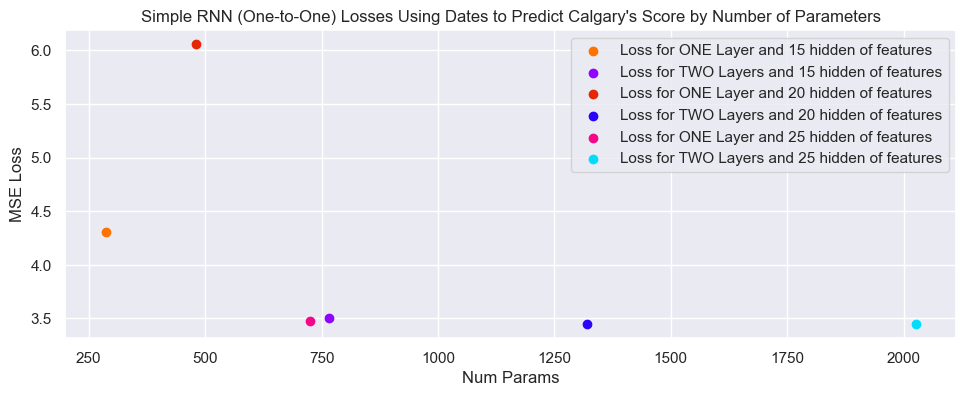

In [9]:
# Plotting the final training loss by the number of parameters
fig_RNN_losses_params, ax_RNN_losses_params = plt.subplots(1)
ax_RNN_losses_params.set_title("Simple RNN (One-to-One) Losses Using Dates to Predict Calgary's Score by Number of Parameters")
for ii in range(0, len(hidden_sizes)):
    ax_RNN_losses_params.scatter(SL_OtO_num_params[ii], all_SL_OtO_losses[ii][-1], color=red_shades[ii], label=f'Loss for ONE Layer and {hidden_sizes[ii]} hidden of features')
    ax_RNN_losses_params.scatter(DL_OtO_num_params[ii], all_DL_OtO_losses[ii][-1], color=blue_shades[ii], label=f'Loss for TWO Layers and {hidden_sizes[ii]} hidden of features')
ax_RNN_losses_params.set_ylabel('MSE Loss')
ax_RNN_losses_params.set_xlabel('Num Params')
ax_RNN_losses_params.legend()
plt.show()

Now let's compare this one-to-one implementation to a many-to-one implementation by using the <br>
last 3 game scores from the previous season to predict the first game's score of the next season.

#### 2B. Last 3 CGY / EDM Scores [ordered by season] to Next CGY / EDM Score (many-to-one)

Let's look at a sample data point and observe changes in the model's parameters.

In [10]:
# Configuring many-to-one data
input_seq_ln = 3
prev_scores = np.zeros(shape=(CGY_scores.shape[0]-1, input_seq_ln, 2))
nxt_scores = np.zeros(shape=(CGY_scores.shape[0]-1, 2))

for ii in range(0, CGY_scores.shape[0]-1):
    for jj in range(0, CGY_scores.shape[1]):
        prev_scores[ii, jj, :] = [CGY_scores[ii, jj], EDM_scores[ii, jj]]
    nxt_scores[ii, :] = [CGY_scores[ii+1, 0], EDM_scores[ii+1, 0]]

print(f'First 3 Games Example')
print(f"Calgary's Scores: {CGY_scores[:1, :]}{CGY_scores[1:2, :]}")
print(f"Edmonton's Scores: {EDM_scores[:1, :]}{EDM_scores[1:2, :]}")
print(f"Previous Scores Tensor: {prev_scores[:1, :1, :]}, {prev_scores[:1, 1:2, :]}, {prev_scores[:1, 2:3, :]}")
print(f"Next Scores Tensor: {nxt_scores[:1, :]}")

# model params
input_val = torch.tensor(prev_scores, dtype=torch.float32)
output_val = torch.tensor(nxt_scores, dtype=torch.float32)

input_size = input_val.shape[2]
hidden_sizes = [15, 20, 25]
output_size = output_val.shape[1]
total_epochs = 150

print(f'\nModel params: \n - Batch Size: {input_val.shape[0]},\n - Input Features Size: {input_size},\n - Input Sequence Size: {input_val.shape[1]},')
print(f' - Number of Hidden Features to Try: {hidden_sizes},\n - Output Features Size: {output_size},\n - Output Sequence Size: {output_val[:, np.newaxis, :].shape[1]}')

First 3 Games Example
Calgary's Scores: [[0. 4. 5.]][[2. 0. 7.]]
Edmonton's Scores: [[4. 2. 2.]][[1. 5. 4.]]
Previous Scores Tensor: [[[0. 4.]]], [[[4. 2.]]], [[[5. 2.]]]
Next Scores Tensor: [[2. 1.]]

Model params: 
 - Batch Size: 9,
 - Input Features Size: 2,
 - Input Sequence Size: 3,
 - Number of Hidden Features to Try: [15, 20, 25],
 - Output Features Size: 2,
 - Output Sequence Size: 1


<details>
  <summary>What happens if the length of the input is of variable length?</summary>

  - Generally, you can padd your input to match the fixed length (rnn.pack_padded_sequence)
</details>

<details>
  <summary>How does a many-to-one model definition differ from a one-to-one?</summary>

  - The element changing is the sequence length of the input
  - The model is configured in a way as to favor the input data's configuration, its up to us to tell it that the output configuration does not 
    follow the input's configuration
  - We need to change what we accept from the output, traditional output shape is [BatchSize, SequenceLength, HiddenSize(NumberOfFeatures)]
  - With only needing 1 sequence element in the output, we can take the last element (since we want to predict one timeStep into the future) 
</details>

In [11]:
# Many-to-One Model Definition
class RNN_DL_Torch_ManyToOne(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_DL_Torch_ManyToOne, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn_2nd = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_val):
        h0 = torch.zeros(1, input_val.size(0), hidden_size).to(input_val.device)
        out, hidden = self.rnn(input_val, h0)
        out, hidden = self.rnn_2nd(out, hidden)
        out = self.fc(out[:, -1, :])
        return out

class RNN_SL_Torch_ManyToOne(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_SL_Torch_ManyToOne, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_val):
        h0 = torch.zeros(1, input_val.size(0), hidden_size).to(input_val.device)
        out, _ = self.rnn(input_val, h0)
        out = self.fc(out[:, -1, :])
        return out

lossFnc = nn.MSELoss()

Does a many-to-one approach affect the training loop implementation?

In [12]:
# Many-to-One Training loop
all_SL_MtO_losses, all_DL_MtO_losses = [], []
SL_MtO_num_params, DL_MtO_num_params  = [], []

for hidden_size in hidden_sizes:
    print(f'For hidden size {hidden_size}', end='\t')
    RNN_SL_MtO_model = RNN_SL_Torch_ManyToOne(input_size, hidden_size, output_size)
    RNN_SL_MtO_train_losses = []
    RNN_SL_MtO_optim = optim.Adam(RNN_SL_MtO_model.parameters(), lr=0.001)
    SL_MtO_num_params.append(sum(p.numel() for p in RNN_SL_MtO_model.parameters() if p.requires_grad))
    print(f'RNN_SL_MtO_Model #trainable parameters: {SL_MtO_num_params[-1]}', end=', ')

    RNN_DL_MtO_model = RNN_DL_Torch_ManyToOne(input_size, hidden_size, output_size)
    RNN_DL_MtO_train_losses = []
    RNN_DL_MtO_optim = optim.Adam(RNN_DL_MtO_model.parameters(), lr=0.001)
    DL_MtO_num_params.append(sum(p.numel() for p in RNN_DL_MtO_model.parameters() if p.requires_grad))
    print(f'RNN_DL_MtO_Model #trainable parameters: {DL_MtO_num_params[-1]}')

    for epoch_num in range(total_epochs):
        # Training
        # Single layer
        RNN_SL_MtO_model.train()
        pred_val_SL_MtO = RNN_SL_MtO_model(input_val)
        RNN_SL_MtO_curr_loss = lossFnc(pred_val_SL_MtO, output_val)

        RNN_SL_MtO_optim.zero_grad()
        RNN_SL_MtO_curr_loss.backward()
        RNN_SL_MtO_optim.step()

        # Two layer
        RNN_DL_MtO_model.train()
        pred_val_DL_MtO = RNN_DL_MtO_model(input_val)
        RNN_DL_MtO_curr_loss = lossFnc(pred_val_DL_MtO, output_val)

        RNN_DL_MtO_optim.zero_grad()
        RNN_DL_MtO_curr_loss.backward()
        RNN_DL_MtO_optim.step()

        if (epoch_num + 1) % 10 == 0:
            RNN_SL_MtO_train_losses.append(round(RNN_SL_MtO_curr_loss.item(), 4))
            RNN_DL_MtO_train_losses.append(round(RNN_DL_MtO_curr_loss.item(), 4))
           
            print(f'For epoch {epoch_num+1} of {total_epochs}, RNN_SL_MtO Train loss: {round(RNN_SL_MtO_curr_loss.item(),4)}', end=', ')
            print(f'RNN_DL_MtO Train loss: {round(RNN_DL_MtO_curr_loss.item(),4)}')

    all_SL_MtO_losses.append(RNN_SL_MtO_train_losses)
    all_DL_MtO_losses.append(RNN_DL_MtO_train_losses)


For hidden size 15	RNN_SL_MtO_Model #trainable parameters: 317, RNN_DL_MtO_Model #trainable parameters: 797
For epoch 10 of 150, RNN_SL_MtO Train loss: 8.9279, RNN_DL_MtO Train loss: 9.0972
For epoch 20 of 150, RNN_SL_MtO Train loss: 7.984, RNN_DL_MtO Train loss: 7.7309
For epoch 30 of 150, RNN_SL_MtO Train loss: 7.0788, RNN_DL_MtO Train loss: 6.4578
For epoch 40 of 150, RNN_SL_MtO Train loss: 6.2275, RNN_DL_MtO Train loss: 5.3512
For epoch 50 of 150, RNN_SL_MtO Train loss: 5.4524, RNN_DL_MtO Train loss: 4.48
For epoch 60 of 150, RNN_SL_MtO Train loss: 4.7727, RNN_DL_MtO Train loss: 3.8342
For epoch 70 of 150, RNN_SL_MtO Train loss: 4.1992, RNN_DL_MtO Train loss: 3.3626
For epoch 80 of 150, RNN_SL_MtO Train loss: 3.7332, RNN_DL_MtO Train loss: 3.0174
For epoch 90 of 150, RNN_SL_MtO Train loss: 3.3656, RNN_DL_MtO Train loss: 2.7642
For epoch 100 of 150, RNN_SL_MtO Train loss: 3.0798, RNN_DL_MtO Train loss: 2.5788
For epoch 110 of 150, RNN_SL_MtO Train loss: 2.8587, RNN_DL_MtO Train loss

Taking a look at some training results, given the limited data, using the last three games would likely be a good predictor of the next game's outcome. 

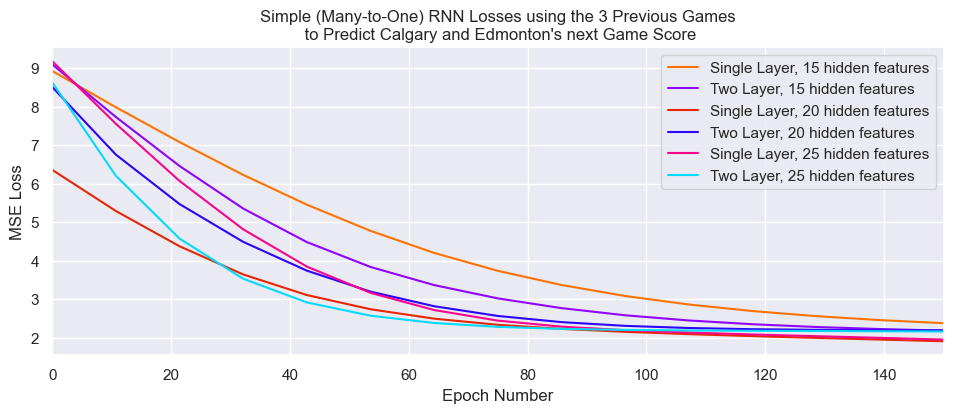

In [13]:
# Plotting Training Losses Across Different Number of Layers and Hidden Features
graph_epochs = np.linspace(0, total_epochs, (total_epochs//10), endpoint=True)

fig_RNN_losses, ax_RNN_losses = plt.subplots(1)
ax_RNN_losses.set_title("Simple (Many-to-One) RNN Losses using the 3 Previous Games\n to Predict Calgary and Edmonton's next Game Score")
for ii in range(0, len(hidden_sizes)):
    ax_RNN_losses.plot(graph_epochs, all_SL_MtO_losses[ii], color=red_shades[ii], label=f'Single Layer, {hidden_sizes[ii]} hidden features')
    ax_RNN_losses.plot(graph_epochs, all_DL_MtO_losses[ii], color=blue_shades[ii], label=f'Two Layer, {hidden_sizes[ii]} hidden features')
ax_RNN_losses.set_ylabel('MSE Loss')
ax_RNN_losses.set_xlabel('Epoch Number')
ax_RNN_losses.set_xlim(0, graph_epochs.max())
ax_RNN_losses.legend()
plt.show()

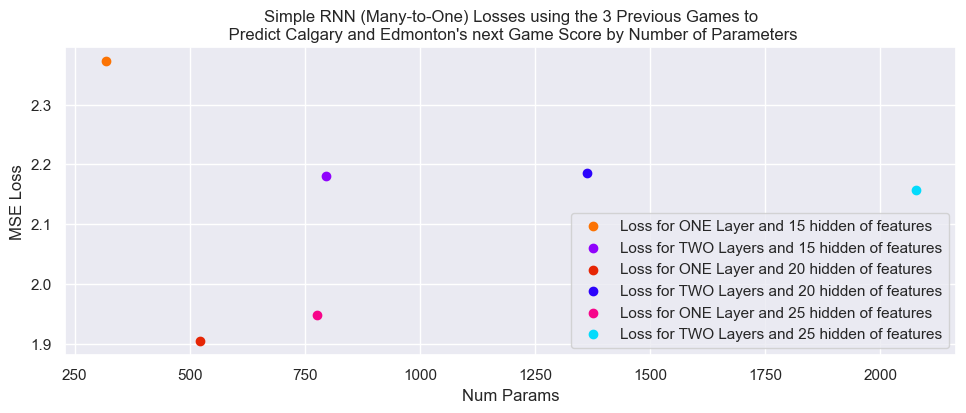

In [14]:
# Plotting the final training loss by the number of parameters
fig_RNN_losses_params, ax_RNN_losses_params = plt.subplots(1)
ax_RNN_losses_params.set_title("Simple RNN (Many-to-One) Losses using the 3 Previous Games to\n Predict Calgary and Edmonton's next Game Score by Number of Parameters")
for ii in range(0, len(hidden_sizes)):
    ax_RNN_losses_params.scatter(SL_MtO_num_params[ii], all_SL_MtO_losses[ii][-1], color=red_shades[ii], label=f'Loss for ONE Layer and {hidden_sizes[ii]} hidden of features')
    ax_RNN_losses_params.scatter(DL_MtO_num_params[ii], all_DL_MtO_losses[ii][-1], color=blue_shades[ii], label=f'Loss for TWO Layers and {hidden_sizes[ii]} hidden of features')
ax_RNN_losses_params.set_ylabel('MSE Loss')
ax_RNN_losses_params.set_xlabel('Num Params')
ax_RNN_losses_params.legend()
plt.show()

Now let's use the last home game score (regardless of season) to predict the next two home game scores.

#### 2C. Given Calgary's last home game score, what will be its next 2 home game scores (one-to-many)

Let's look at a sample data point and model parameters when the problem is reversed (many-to-one -> one-to-many).

In [15]:
# Configuring one-to-many data
hg_mask = df['Home Team'].str.contains('CGY', case=False, na=False)
hg_df = df[hg_mask]
output_seq_ln = 2
last_Hgame_score = np.zeros(shape=(int(hg_df.shape[0]//3), 1, 2))
next_2_Hgame_scores = np.zeros(shape=(int(hg_df.shape[0]//3), output_seq_ln, 2))
seq_ind, samp_ind = 0, -1

for ii in range(0, int(hg_df.shape[0]//3)*3):
    if (ii%3)==0:
        samp_ind+=1
        last_Hgame_score[samp_ind, 0, :] = [hg_df.iloc[ii]['Calgary Score'], hg_df.iloc[ii]['Edmonton Score']]
        seq_ind = 0
    else:
        next_2_Hgame_scores[samp_ind, seq_ind, :] = [hg_df.iloc[ii]['Calgary Score'], hg_df.iloc[ii]['Edmonton Score']]
        seq_ind += 1

print(f'First 3 Home Games Example')
print(f"CGY Score: {hg_df.iloc[:1]['Calgary Score'].to_string(index=False)}, {hg_df.iloc[1:2]['Calgary Score'].to_string(index=False)}, {hg_df.iloc[2:3]['Calgary Score'].to_string(index=False)}")
print(f"EDM Score: {hg_df.iloc[:1]['Edmonton Score'].to_string(index=False)}, {hg_df.iloc[1:2]['Edmonton Score'].to_string(index=False)}, {hg_df.iloc[2:3]['Edmonton Score'].to_string(index=False)}")
print(f"Last Home Game Score: {last_Hgame_score[:1, :, :]}")
print(f"Next Home Game Score: {next_2_Hgame_scores[:1, :1, :]}, {next_2_Hgame_scores[:1, 1:2, :]}")

# model params
input_val = torch.tensor(last_Hgame_score, dtype=torch.float32)
output_val = torch.tensor(next_2_Hgame_scores, dtype=torch.float32)

input_size = input_val.shape[2]
hidden_sizes = [15, 20, 25]
output_size = output_val.shape[1]
total_epochs = 150

print(f'\nModel params: \n - Batch Size: {input_val.shape[0]},\n - Input Features Size: {input_size},\n - Input Sequence Size: {input_val.shape[1]},')
print(f' - Number of Hidden Features to Try: {hidden_sizes},\n - Output Features Size: {output_size},\n - Output Sequence Size: {output_val[:, np.newaxis, :].shape[1]}')

First 3 Home Games Example
CGY Score: 4, 2, 5
EDM Score: 0, 4, 4
Last Home Game Score: [[[4. 0.]]]
Next Home Game Score: [[[2. 4.]]], [[[5. 4.]]]

Model params: 
 - Batch Size: 10,
 - Input Features Size: 2,
 - Input Sequence Size: 1,
 - Number of Hidden Features to Try: [15, 20, 25],
 - Output Features Size: 2,
 - Output Sequence Size: 1


<details>
  <summary>How does a one-to-many model definition differ from a one-to-one?</summary>

  - The element changing is the number of elements in the output sequence
  - Since one input only provides one time step into the future, how do we produce more future outputs?
  - One way is to repeat the input sequence and padd itself with multiple copies
</details>

In [16]:
# One-to-Many Model Definition
class RNN_DL_Torch_OneToMany(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_DL_Torch_OneToMany, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn_2nd = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_val):
        h0 = torch.zeros(1, input_val.size(0), hidden_size).to(input_val.device)
        out, hidden = self.rnn(input_val.repeat(1, 2, 1), h0)
        out, hidden = self.rnn_2nd(out, hidden)
        out = self.fc(out)
        
        return out

class RNN_SL_Torch_OneToMany(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_SL_Torch_OneToMany, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_val):
        h0 = torch.zeros(1, input_val.size(0), hidden_size).to(input_val.device)
        out, hidden  = self.rnn(input_val.repeat(1, 2, 1), h0)
        out = self.fc(out)

        return out

lossFnc = nn.MSELoss()

Does the training loop change?

In [17]:
# One-to-Many Training loop
all_SL_OtM_losses, all_DL_OtM_losses = [], []
SL_OtM_num_params, DL_OtM_num_params  = [], []

for hidden_size in hidden_sizes:
    print(f'For hidden size {hidden_size}', end='\t')
    RNN_SL_OtM_model = RNN_SL_Torch_OneToMany(input_size, hidden_size, output_size)
    RNN_SL_OtM_train_losses = []
    RNN_SL_OtM_optim = optim.Adam(RNN_SL_OtM_model.parameters(), lr=0.001)
    SL_OtM_num_params.append(sum(p.numel() for p in RNN_SL_OtM_model.parameters() if p.requires_grad))
    print(f'RNN_SL_OtM_Model #trainable parameters: {SL_OtM_num_params[-1]}', end=', ')

    RNN_DL_OtM_model = RNN_DL_Torch_OneToMany(input_size, hidden_size, output_size)
    RNN_DL_OtM_train_losses = []
    RNN_DL_OtM_optim = optim.Adam(RNN_DL_OtM_model.parameters(), lr=0.001)
    DL_OtM_num_params.append(sum(p.numel() for p in RNN_DL_OtM_model.parameters() if p.requires_grad))
    print(f'RNN_DL_OtM_Model #trainable parameters: {DL_OtM_num_params[-1]}')

    for epoch_num in range(total_epochs):
        # Training
        # Single layer
        RNN_SL_OtM_model.train()
        pred_val_SL_OtM = RNN_SL_OtM_model(input_val)
        RNN_SL_OtM_curr_loss = lossFnc(pred_val_SL_OtM, output_val)

        RNN_SL_OtM_optim.zero_grad()
        RNN_SL_OtM_curr_loss.backward()
        RNN_SL_OtM_optim.step()

        # Two layer
        RNN_DL_OtM_model.train()
        pred_val_DL_OtM = RNN_DL_OtM_model(input_val)
        RNN_DL_OtM_curr_loss = lossFnc(pred_val_DL_OtM, output_val)

        RNN_DL_OtM_optim.zero_grad()
        RNN_DL_OtM_curr_loss.backward()
        RNN_DL_OtM_optim.step()
    
        if (epoch_num + 1) % 10 == 0:
            RNN_SL_OtM_train_losses.append(round(RNN_SL_OtM_curr_loss.item(), 4))
            RNN_DL_OtM_train_losses.append(round(RNN_DL_OtM_curr_loss.item(), 4))

            print(f'For epoch {epoch_num+1} of {total_epochs}, RNN_SL_OtM Train loss: {round(RNN_SL_OtM_curr_loss.item(),4)}', end=', ')
            print(f'RNN_DL_OtM Train loss: {round(RNN_DL_OtM_curr_loss.item(),4)}', end='\n')

    all_SL_OtM_losses.append(RNN_SL_OtM_train_losses)
    all_DL_OtM_losses.append(RNN_DL_OtM_train_losses)


For hidden size 15	RNN_SL_OtM_Model #trainable parameters: 317, RNN_DL_OtM_Model #trainable parameters: 797
For epoch 10 of 150, RNN_SL_OtM Train loss: 16.6697, RNN_DL_OtM Train loss: 14.9186
For epoch 20 of 150, RNN_SL_OtM Train loss: 15.5054, RNN_DL_OtM Train loss: 13.2013
For epoch 30 of 150, RNN_SL_OtM Train loss: 14.4013, RNN_DL_OtM Train loss: 11.612
For epoch 40 of 150, RNN_SL_OtM Train loss: 13.3427, RNN_DL_OtM Train loss: 10.1608
For epoch 50 of 150, RNN_SL_OtM Train loss: 12.3353, RNN_DL_OtM Train loss: 8.874
For epoch 60 of 150, RNN_SL_OtM Train loss: 11.391, RNN_DL_OtM Train loss: 7.786
For epoch 70 of 150, RNN_SL_OtM Train loss: 10.5245, RNN_DL_OtM Train loss: 6.9189
For epoch 80 of 150, RNN_SL_OtM Train loss: 9.7483, RNN_DL_OtM Train loss: 6.2619
For epoch 90 of 150, RNN_SL_OtM Train loss: 9.0645, RNN_DL_OtM Train loss: 5.7794
For epoch 100 of 150, RNN_SL_OtM Train loss: 8.4652, RNN_DL_OtM Train loss: 5.4303
For epoch 110 of 150, RNN_SL_OtM Train loss: 7.9387, RNN_DL_OtM 

Looking at some training results, our current model may make more mistakes when using a single game to predict multiple future games,<br> 
though this is not completely unanticipated as this is intuitively a more difficult problem for our model to tackle.

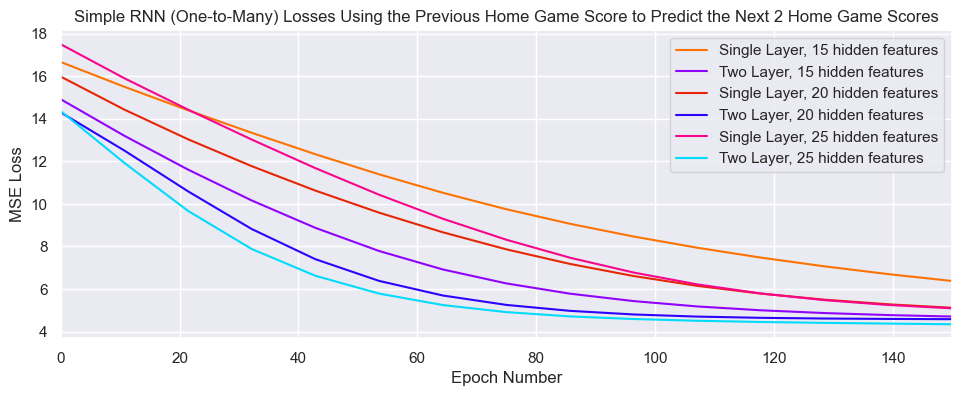

In [18]:
# Plotting Training Losses Across Different Number of Layers and Hidden Features
graph_epochs = np.linspace(0, total_epochs, (total_epochs//10), endpoint=True)

fig_RNN_losses, ax_RNN_losses = plt.subplots(1)
ax_RNN_losses.set_title("Simple RNN (One-to-Many) Losses Using the Previous Home Game Score to Predict the Next 2 Home Game Scores")
for ii in range(0, len(hidden_sizes)):
    ax_RNN_losses.plot(graph_epochs, all_SL_OtM_losses[ii], color=red_shades[ii], label=f'Single Layer, {hidden_sizes[ii]} hidden features')
    ax_RNN_losses.plot(graph_epochs, all_DL_OtM_losses[ii], color=blue_shades[ii], label=f'Two Layer, {hidden_sizes[ii]} hidden features')
ax_RNN_losses.set_ylabel('MSE Loss')
ax_RNN_losses.set_xlabel('Epoch Number')
ax_RNN_losses.set_xlim(0, graph_epochs.max())
ax_RNN_losses.legend()
plt.show()

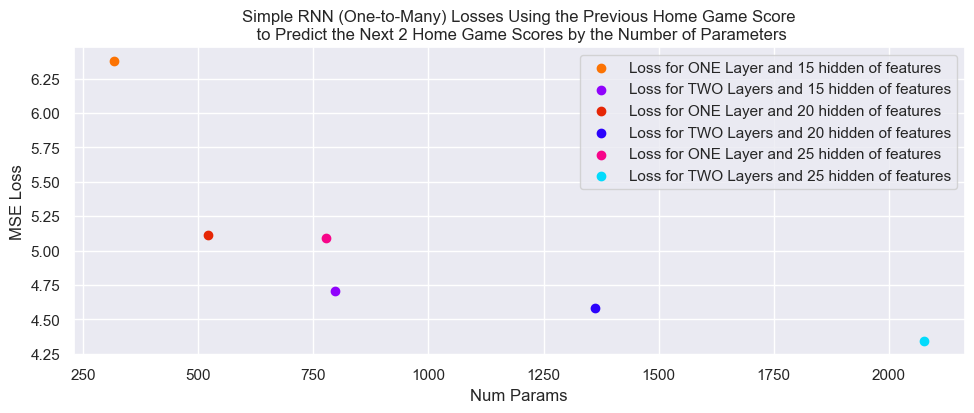

In [19]:
# Plotting the final training loss by the number of parameters
fig_RNN_losses_params, ax_RNN_losses_params = plt.subplots(1)
ax_RNN_losses_params.set_title("Simple RNN (One-to-Many) Losses Using the Previous Home Game Score\n to Predict the Next 2 Home Game Scores by the Number of Parameters")
for ii in range(0, len(hidden_sizes)):
    ax_RNN_losses_params.scatter(SL_OtM_num_params[ii], all_SL_OtM_losses[ii][-1], color=red_shades[ii], label=f'Loss for ONE Layer and {hidden_sizes[ii]} hidden of features')
    ax_RNN_losses_params.scatter(DL_OtM_num_params[ii], all_DL_OtM_losses[ii][-1], color=blue_shades[ii], label=f'Loss for TWO Layers and {hidden_sizes[ii]} hidden of features')
ax_RNN_losses_params.set_ylabel('MSE Loss')
ax_RNN_losses_params.set_xlabel('Num Params')
ax_RNN_losses_params.legend()
plt.show()

Now let's look at one last RNN example where we'll use multiple past data points to predict multiple future data points!

#### 2D. Based on Calgary's last 2 games per period scoring, what will be Calgary's next 2 games final scores (many-to-many)

Let's look at a sample data point and model parameters when the complexity of the input and output increase.

In [20]:
# Configuring many-to-many data
per_period_scores_CGY = np.zeros(shape=(int(df['1st Period - CGY'].shape[0]//4), 2, 3))
final_scores_CGY = np.zeros(shape=(int(df['1st Period - CGY'].shape[0]//4), 2, 1))
seq_ind_i, seq_ind_o, samp_ind = 0, 2, 0

for ii in range(1, (int(df['1st Period - CGY'].shape[0]//4)*4)+1):
    if seq_ind_o<2 and seq_ind_i!=1:
        final_scores_CGY[samp_ind, seq_ind_o, 0] = int(df.iloc[ii-1]['Calgary Score'])
        seq_ind_o += 1
        seq_ind_i = 0
    else:
        per_period_scores_CGY[samp_ind, seq_ind_i, :] = [int(df.iloc[ii-1]['1st Period - CGY']), int(df.iloc[ii-1]['2nd Period - CGY']), int(df.iloc[ii-1]['3rd Period - CGY'])]
        seq_ind_i += 1
        seq_ind_o = 0
    if (ii%4==0) and ii!=0:
        samp_ind+=1

print(f'First 2 Games Example')
print(f"CGY per Period Score (last 2 games): {int(df.iloc[0]['1st Period - CGY'])}, {int(df.iloc[0]['2nd Period - CGY'])}, {int(df.iloc[0]['3rd Period - CGY'])}", end='')
print(f"\t {int(df.iloc[1]['1st Period - CGY'])}, {int(df.iloc[1]['2nd Period - CGY'])}, {int(df.iloc[1]['3rd Period - CGY'])}")
print(f"CGY Final Score (next 2 games): {df.iloc[2:3]['Calgary Score'].to_string(index=False)}, {df.iloc[3:4]['Calgary Score'].to_string(index=False)}")
print(f"Per period scores: {per_period_scores_CGY[:1, :1, :]}, {per_period_scores_CGY[:1, 1:2, :]}")
print(f"Per game scores: {final_scores_CGY[:1, :1, :]}, {final_scores_CGY[:1, 1:2, :]}")

# model params
input_val = torch.tensor(per_period_scores_CGY, dtype=torch.float32)
output_val = torch.tensor(final_scores_CGY, dtype=torch.float32)

input_size = input_val.shape[2]
hidden_sizes = [15, 20, 25]
output_size = output_val.shape[2]
total_epochs = 150

print(f'\nModel params: \n - Batch Size: {input_val.shape[0]},\n - Input Features Size: {input_size},\n - Input Sequence Size: {input_val.shape[1]},')
print(f' - Number of Hidden Features to Try: {hidden_sizes},\n - Output Features Size: {output_size},\n - Output Sequence Size: {output_val[:, np.newaxis, :].shape[1]}')

First 2 Games Example
CGY per Period Score (last 2 games): 1, 1, 2	 1, 1, 0
CGY Final Score (next 2 games): 2, 5
Per period scores: [[[1. 1. 2.]]], [[[1. 1. 0.]]]
Per game scores: [[[2.]]], [[[5.]]]

Model params: 
 - Batch Size: 15,
 - Input Features Size: 3,
 - Input Sequence Size: 2,
 - Number of Hidden Features to Try: [15, 20, 25],
 - Output Features Size: 1,
 - Output Sequence Size: 1


<details>
  <summary>How does the model configuration change from a one-to-one to many-to-many?</summary>

  - It depends on whether the input configuration matches (or not) the output configuration
  - If it matches --> One-to-one model definition can work with input and output sequence lengths > 1 but equal with each other
  - If they don't match --> Adjustments need to be made based on whether the input sequence length is >(greater than) output (take last value)  
    or <(less than) output (repeat/padd input)
</details>

In [21]:
# Many-to-Many Model Definitions
class RNN_DL_Torch_ManyToMany(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_DL_Torch_ManyToMany, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn_2nd = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_val):
        h0 = torch.zeros(1, input_val.size(0), hidden_size).to(input_val.device)
        out, hidden = self.rnn(input_val, h0)
        out, hidden = self.rnn_2nd(out, hidden)
        out = self.fc(out)
        
        return out

class RNN_SL_Torch_ManyToMany(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_SL_Torch_ManyToMany, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_val):
        h0 = torch.zeros(1, input_val.size(0), hidden_size).to(input_val.device)
        out, hidden  = self.rnn(input_val, h0)
        out = self.fc(out)

        return out

lossFnc = nn.MSELoss()

Does the training loop change? Similar to the model definition, does it change when the input and outputs have different sequence lenghts?

In [22]:
# Many-to-Many Training loop
all_SL_MtM_losses, all_DL_MtM_losses = [], []
SL_MtM_num_params, DL_MtM_num_params  = [], []

for hidden_size in hidden_sizes:
    print(f'For hidden size {hidden_size}', end='\t')
    RNN_SL_MtM_model = RNN_SL_Torch_ManyToMany(input_size, hidden_size, output_size)
    RNN_SL_MtM_train_losses = []
    RNN_SL_MtM_optim = optim.Adam(RNN_SL_MtM_model.parameters(), lr=0.001)
    SL_MtM_num_params.append(sum(p.numel() for p in RNN_SL_MtM_model.parameters() if p.requires_grad))
    print(f'RNN_SL_MtM_Model #trainable parameters: {SL_MtM_num_params[-1]}', end=', ')

    RNN_DL_MtM_model = RNN_DL_Torch_ManyToMany(input_size, hidden_size, output_size)
    RNN_DL_MtM_train_losses = []
    RNN_DL_MtM_optim = optim.Adam(RNN_DL_MtM_model.parameters(), lr=0.001)
    DL_MtM_num_params.append(sum(p.numel() for p in RNN_DL_MtM_model.parameters() if p.requires_grad))
    print(f'RNN_DL_MtM_Model #trainable parameters: {DL_MtM_num_params[-1]}')

    for epoch_num in range(total_epochs):
        # Training
        # Single layer
        RNN_SL_MtM_model.train()
        pred_val_SL_MtM = RNN_SL_MtM_model(input_val)
        RNN_SL_MtM_curr_loss = lossFnc(pred_val_SL_MtM, output_val)

        RNN_SL_MtM_optim.zero_grad()
        RNN_SL_MtM_curr_loss.backward()
        RNN_SL_MtM_optim.step()

        # Two layer
        RNN_DL_MtM_model.train()
        pred_val_DL_MtM = RNN_DL_MtM_model(input_val)
        RNN_DL_MtM_curr_loss = lossFnc(pred_val_DL_MtM, output_val)

        RNN_DL_MtM_optim.zero_grad()
        RNN_DL_MtM_curr_loss.backward()
        RNN_DL_MtM_optim.step()
        
        if (epoch_num + 1) % 10 == 0:
            RNN_SL_MtM_train_losses.append(round(RNN_SL_MtM_curr_loss.item(), 4))
            RNN_DL_MtM_train_losses.append(round(RNN_DL_MtM_curr_loss.item(), 4))

            print(f'For epoch {epoch_num+1} of {total_epochs}, RNN_SL_MtM Train loss: {round(RNN_SL_MtM_curr_loss.item(),4)}', end=', ')
            print(f'RNN_DL_MtM Train loss: {round(RNN_DL_MtM_curr_loss.item(),4)}', end='\n')

    all_SL_MtM_losses.append(RNN_SL_MtM_train_losses)
    all_DL_MtM_losses.append(RNN_DL_MtM_train_losses)


For hidden size 15	RNN_SL_MtM_Model #trainable parameters: 316, RNN_DL_MtM_Model #trainable parameters: 796
For epoch 10 of 150, RNN_SL_MtM Train loss: 12.8492, RNN_DL_MtM Train loss: 10.0434
For epoch 20 of 150, RNN_SL_MtM Train loss: 11.7649, RNN_DL_MtM Train loss: 8.5714
For epoch 30 of 150, RNN_SL_MtM Train loss: 10.7813, RNN_DL_MtM Train loss: 7.1332
For epoch 40 of 150, RNN_SL_MtM Train loss: 9.8855, RNN_DL_MtM Train loss: 5.826
For epoch 50 of 150, RNN_SL_MtM Train loss: 9.0632, RNN_DL_MtM Train loss: 4.7861
For epoch 60 of 150, RNN_SL_MtM Train loss: 8.3035, RNN_DL_MtM Train loss: 4.065
For epoch 70 of 150, RNN_SL_MtM Train loss: 7.6024, RNN_DL_MtM Train loss: 3.6201
For epoch 80 of 150, RNN_SL_MtM Train loss: 6.9612, RNN_DL_MtM Train loss: 3.3678
For epoch 90 of 150, RNN_SL_MtM Train loss: 6.3822, RNN_DL_MtM Train loss: 3.2322
For epoch 100 of 150, RNN_SL_MtM Train loss: 5.8659, RNN_DL_MtM Train loss: 3.1619
For epoch 110 of 150, RNN_SL_MtM Train loss: 5.4104, RNN_DL_MtM Train

After plotting some training results we see the model may have a similar error as the one-to-many example.<br> 
This may indicate that additional features and layers would be required when predicting multiple future time points regardless of the number of inputs.

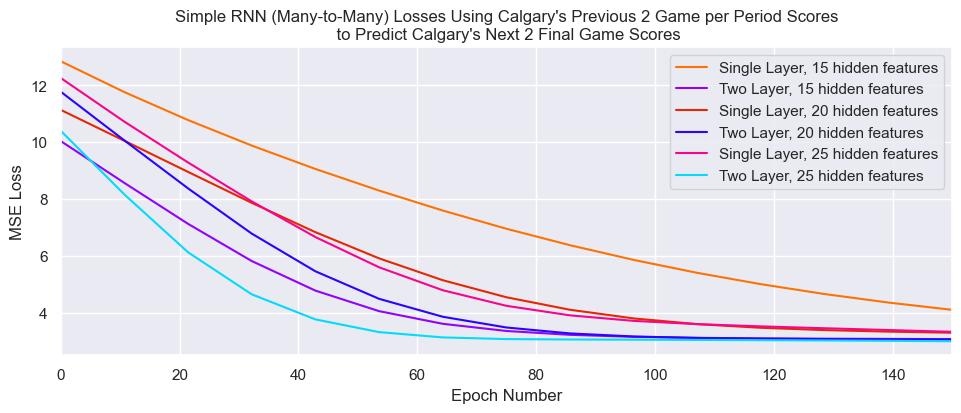

In [23]:
# Plotting Training Losses Across Different Number of Layers and Hidden Features
graph_epochs = np.linspace(0, total_epochs, (total_epochs//10), endpoint=True)

fig_RNN_losses, ax_RNN_losses = plt.subplots(1)
ax_RNN_losses.set_title("Simple RNN (Many-to-Many) Losses Using Calgary's Previous 2 Game per Period Scores\n to Predict Calgary's Next 2 Final Game Scores")
for ii in range(0, len(hidden_sizes)):
    ax_RNN_losses.plot(graph_epochs, all_SL_MtM_losses[ii], color=red_shades[ii], label=f'Single Layer, {hidden_sizes[ii]} hidden features')
    ax_RNN_losses.plot(graph_epochs, all_DL_MtM_losses[ii], color=blue_shades[ii], label=f'Two Layer, {hidden_sizes[ii]} hidden features')
ax_RNN_losses.set_ylabel('MSE Loss')
ax_RNN_losses.set_xlabel('Epoch Number')
ax_RNN_losses.set_xlim(0, graph_epochs.max())
ax_RNN_losses.legend()
plt.show()

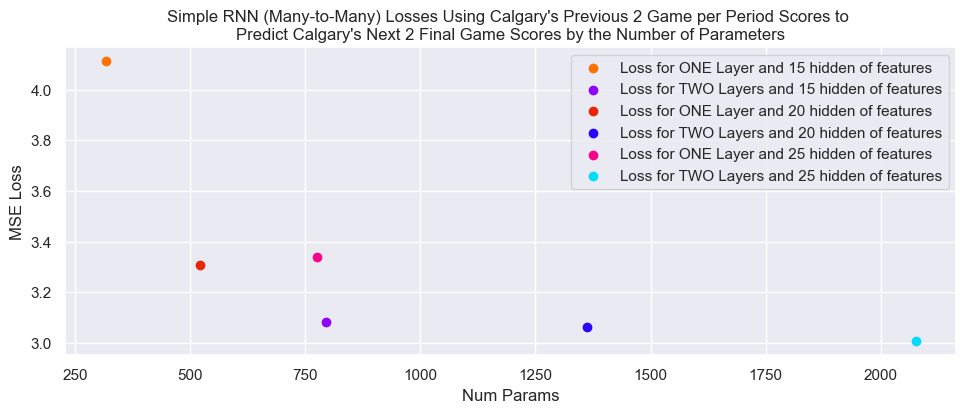

In [24]:
# Plotting the final training loss by the number of parameters
fig_RNN_losses_params, ax_RNN_losses_params = plt.subplots(1)
ax_RNN_losses_params.set_title("Simple RNN (Many-to-Many) Losses Using Calgary's Previous 2 Game per Period Scores to \nPredict Calgary's Next 2 Final Game Scores by the Number of Parameters")
for ii in range(0, len(hidden_sizes)):
    ax_RNN_losses_params.scatter(SL_MtM_num_params[ii], all_SL_MtM_losses[ii][-1], color=red_shades[ii], label=f'Loss for ONE Layer and {hidden_sizes[ii]} hidden of features')
    ax_RNN_losses_params.scatter(DL_MtM_num_params[ii], all_DL_MtM_losses[ii][-1], color=blue_shades[ii], label=f'Loss for TWO Layers and {hidden_sizes[ii]} hidden of features')
ax_RNN_losses_params.set_ylabel('MSE Loss')
ax_RNN_losses_params.set_xlabel('Num Params')
ax_RNN_losses_params.legend()
plt.show()

Now let's look a bit further at the most successful implementation (as determined by training results only). <br>
Below is the many-to-one example, using the last 3 Calgary / Edmonton games scores from the previous season to <br>
predict the first Calgary / Edmonton game score of the next season this time using an LSTM model.

### 2. LSTM Model Design

Since our data is already configured, we will just use the same data as used by the RNN model for the Many-to-One example and recap the data below.

In [141]:
# Reconfiguring many-to-one data
# Configuring many-to-one data
input_seq_ln = 3
num_teams = 2
prev_scores = np.zeros(shape=((all_CGY_scores.shape[0]-input_seq_ln)//(input_seq_ln+1), input_seq_ln, num_teams))
nxt_scores = np.zeros(shape=((all_CGY_scores.shape[0]-input_seq_ln)//(input_seq_ln+1), num_teams))
test_scores = np.zeros(shape=(1, input_seq_ln, num_teams))

range_val = (all_CGY_scores.shape[0]-input_seq_ln)//(input_seq_ln+1)
for ii in range(0, range_val):
    prev_scores[ii, :, :] = np.array([all_CGY_scores[ii*4:(ii*4)+3], all_EDM_scores[ii*4:(ii*4)+3]]).T
    nxt_scores[ii, :] = np.array([all_CGY_scores[(ii*4)+3:(ii*4)+4], all_EDM_scores[(ii*4)+3:(ii*4)+4]]).squeeze()

test_scores[0, :, :] = np.array([all_CGY_scores[all_CGY_scores.shape[0]-input_seq_ln:], all_EDM_scores[all_CGY_scores.shape[0]-input_seq_ln:]]).T

print(f'First 3 Games Example')
print(f"Calgary's Scores: {all_CGY_scores[:1]}, {all_CGY_scores[1:2]}, {all_CGY_scores[2:3]}, {all_CGY_scores[3:4]}")
print(f"Edmonton's Scores: {all_EDM_scores[:1]}, {all_EDM_scores[1:2]}, {all_EDM_scores[2:3]}, {all_EDM_scores[3:4]}")
print(f"Previous Scores Tensor: {prev_scores[:1, :1, :]}, {prev_scores[:1, 1:2, :]}, {prev_scores[:1, 2:3, :]}")
print(f"Next Scores Tensor: {nxt_scores[:1, :]}")
print(f"Scores Used to Predict Next **--REAL--** Game: {test_scores[0, :1, :]}, {test_scores[0, 1:2, :]}, {test_scores[0, 2:3, :]}")
# model params
input_val = torch.tensor(prev_scores, dtype=torch.float32)
output_val = torch.tensor(nxt_scores, dtype=torch.float32)

input_size = input_val.shape[2]
hidden_sizes = [15, 20, 25]
output_size = output_val.shape[1]
total_epochs = 150

# model params
input_val = torch.tensor(prev_scores, dtype=torch.float32)
output_val = torch.tensor(nxt_scores, dtype=torch.float32)

input_size = input_val.shape[2]
hidden_sizes = [15, 20, 25]
output_size = output_val.shape[1]
total_epochs = 150

print(f'\nModel params: \n - Batch Size: {input_val.shape[0]},\n - Input Features Size: {input_size},\n - Input Sequence Size: {input_val.shape[1]},')
print(f' - Number of Hidden Features to Try: {hidden_sizes},\n - Output Features Size: {output_size},\n - Output Sequence Size: {output_val[:, np.newaxis, :].shape[1]}')

First 3 Games Example
Calgary's Scores: [4], [2], [2], [5]
Edmonton's Scores: [0], [4], [5], [4]
Previous Scores Tensor: [[[4. 0.]]], [[[2. 4.]]], [[[2. 5.]]]
Next Scores Tensor: [[5. 4.]]
Scores Used to Predict Next **--REAL--** Game: [[6. 1.]], [[4. 1.]], [[2. 4.]]

Model params: 
 - Batch Size: 14,
 - Input Features Size: 2,
 - Input Sequence Size: 3,
 - Number of Hidden Features to Try: [15, 20, 25],
 - Output Features Size: 2,
 - Output Sequence Size: 1


In [142]:
# Many-to-One RNN model definition and training loop
class RNN_SL_Torch_ManyToOne(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_SL_Torch_ManyToOne, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_val):
        h0 = torch.zeros(1, input_val.size(0), hidden_size).to(input_val.device)
        out, _ = self.rnn(input_val, h0)
        out = self.fc(out[:, -1, :])
        return out

lossFnc = nn.MSELoss()

# Many-to-One Training loop
all_SL_MtO_losses = []
SL_MtO_num_params  = []

for hidden_size in hidden_sizes:
    print(f'For hidden size {hidden_size}', end='\t')
    RNN_SL_MtO_model = RNN_SL_Torch_ManyToOne(input_size, hidden_size, output_size)
    RNN_SL_MtO_train_losses = []
    RNN_SL_MtO_optim = optim.Adam(RNN_SL_MtO_model.parameters(), lr=0.001)
    SL_MtO_num_params.append(sum(p.numel() for p in RNN_SL_MtO_model.parameters() if p.requires_grad))
    print(f'RNN_SL_MtO_Model #trainable parameters: {SL_MtO_num_params[-1]}', end=', ')

    best_val_loss = 1000
    best_weights = []
    
    for epoch_num in range(total_epochs):
        # Training
        # Single layer
        RNN_SL_MtO_model.train()
        pred_val_SL_MtO = RNN_SL_MtO_model(input_val)
        RNN_SL_MtO_curr_loss = lossFnc(pred_val_SL_MtO, output_val)

        RNN_SL_MtO_optim.zero_grad()
        RNN_SL_MtO_curr_loss.backward()
        RNN_SL_MtO_optim.step()

        if (hidden_size == max(hidden_sizes)) and (RNN_SL_MtO_curr_loss < best_val_loss):
            best_weights = RNN_SL_MtO_model.state_dict()
            best_val_loss = RNN_SL_MtO_curr_loss

        if (epoch_num + 1) % 10 == 0:
            RNN_SL_MtO_train_losses.append(round(RNN_SL_MtO_curr_loss.item(), 4))
           
            print(f'For epoch {epoch_num+1} of {total_epochs}, RNN_SL_MtO Train loss: {round(RNN_SL_MtO_curr_loss.item(),4)}')

    all_SL_MtO_losses.append(RNN_SL_MtO_train_losses)
    
    if best_weights:
        torch.save(best_weights, "NextHockeyGame_RNN.pt")

For hidden size 15	RNN_SL_MtO_Model #trainable parameters: 317, For epoch 10 of 150, RNN_SL_MtO Train loss: 18.217
For epoch 20 of 150, RNN_SL_MtO Train loss: 16.8811
For epoch 30 of 150, RNN_SL_MtO Train loss: 15.6232
For epoch 40 of 150, RNN_SL_MtO Train loss: 14.4092
For epoch 50 of 150, RNN_SL_MtO Train loss: 13.2143
For epoch 60 of 150, RNN_SL_MtO Train loss: 12.039
For epoch 70 of 150, RNN_SL_MtO Train loss: 10.914
For epoch 80 of 150, RNN_SL_MtO Train loss: 9.8783
For epoch 90 of 150, RNN_SL_MtO Train loss: 8.9587
For epoch 100 of 150, RNN_SL_MtO Train loss: 8.1637
For epoch 110 of 150, RNN_SL_MtO Train loss: 7.4865
For epoch 120 of 150, RNN_SL_MtO Train loss: 6.9131
For epoch 130 of 150, RNN_SL_MtO Train loss: 6.4287
For epoch 140 of 150, RNN_SL_MtO Train loss: 6.0201
For epoch 150 of 150, RNN_SL_MtO Train loss: 5.6762
For hidden size 20	RNN_SL_MtO_Model #trainable parameters: 522, For epoch 10 of 150, RNN_SL_MtO Train loss: 15.0375
For epoch 20 of 150, RNN_SL_MtO Train loss: 1

<details>
  <summary>Now looking only at a single layer model example, how does the architecture change for an LSTM model?</summary>

  - Of course layer name but for the most part the requirements of inputSize, hiddenSize and numLayers are still required
  - Now we have the cell state to consider as well, we should (similarly to h0) initialize c0 to be 0
</details>

In [143]:
# Many-to-One LSTM model definition
class LSTM_SL_Torch_ManyToOne(nn.Module):
    def __init__(self, input_size, hidden_dim, num_outputs):
        super(LSTM_SL_Torch_ManyToOne, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_outputs)
    
    def forward(self, input_val):
        h0 = torch.zeros(1, input_val.size(0), self.hidden_dim).to(input_val.device)
        c0 = torch.zeros(1, input_val.size(0), self.hidden_dim).to(input_val.device)
        out, _ = self.lstm(input_val, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

lossFnc = nn.MSELoss()

In [144]:
# Many-to-One LSTM Training loop
LSTM_SL_MtO_losses, LSTM_SL_MtO_num_params  = [], []

for hidden_size in hidden_sizes:
    print(f'For hidden size {hidden_size}', end='\t')
    LSTM_SL_MtO_model = LSTM_SL_Torch_ManyToOne(input_size, hidden_size, output_size)
    LSTM_SL_MtO_train_losses = []
    LSTM_SL_MtO_optim = optim.Adam(LSTM_SL_MtO_model.parameters(), lr=0.001)
    LSTM_SL_MtO_num_params.append(sum(p.numel() for p in LSTM_SL_MtO_model.parameters() if p.requires_grad))
    print(f'LSTM_SL_MtO_Model #trainable parameters: {sum(p.numel() for p in LSTM_SL_MtO_model.parameters() if p.requires_grad)}', end=', ')

    best_val_loss = 1000
    best_weights = []

    for epoch_num in range(total_epochs):
        # Training
        # Single layer
        LSTM_SL_MtO_model.train()
        pred_val_LSTM_SL_MtO = LSTM_SL_MtO_model(input_val)
        LSTM_SL_MtO_curr_loss = lossFnc(pred_val_LSTM_SL_MtO, output_val)

        LSTM_SL_MtO_optim.zero_grad()
        LSTM_SL_MtO_curr_loss.backward()
        LSTM_SL_MtO_optim.step()
        
        if (hidden_size == max(hidden_sizes)) and (LSTM_SL_MtO_curr_loss < best_val_loss):
            best_weights = LSTM_SL_MtO_model.state_dict()
            best_val_loss = LSTM_SL_MtO_curr_loss

        if (epoch_num + 1) % 10 == 0:
            LSTM_SL_MtO_train_losses.append(round(LSTM_SL_MtO_curr_loss.item(), 4))
            print(f'For epoch {epoch_num+1} of {total_epochs}, LSTM_SL_MtO Train loss: {round(LSTM_SL_MtO_curr_loss.item(),4)}', end='\n')

    LSTM_SL_MtO_losses.append(LSTM_SL_MtO_train_losses)

    if best_weights:
        torch.save(best_weights, "NextHockeyGame_LSTM.pt")


For hidden size 15	LSTM_SL_MtO_Model #trainable parameters: 1172, For epoch 10 of 150, LSTM_SL_MtO Train loss: 16.4161
For epoch 20 of 150, LSTM_SL_MtO Train loss: 15.6932
For epoch 30 of 150, LSTM_SL_MtO Train loss: 15.0185
For epoch 40 of 150, LSTM_SL_MtO Train loss: 14.3444
For epoch 50 of 150, LSTM_SL_MtO Train loss: 13.6196
For epoch 60 of 150, LSTM_SL_MtO Train loss: 12.8039
For epoch 70 of 150, LSTM_SL_MtO Train loss: 11.8883
For epoch 80 of 150, LSTM_SL_MtO Train loss: 10.9079
For epoch 90 of 150, LSTM_SL_MtO Train loss: 9.9249
For epoch 100 of 150, LSTM_SL_MtO Train loss: 8.996
For epoch 110 of 150, LSTM_SL_MtO Train loss: 8.1567
For epoch 120 of 150, LSTM_SL_MtO Train loss: 7.4211
For epoch 130 of 150, LSTM_SL_MtO Train loss: 6.7874
For epoch 140 of 150, LSTM_SL_MtO Train loss: 6.246
For epoch 150 of 150, LSTM_SL_MtO Train loss: 5.7874
For hidden size 20	LSTM_SL_MtO_Model #trainable parameters: 1962, For epoch 10 of 150, LSTM_SL_MtO Train loss: 17.7946
For epoch 20 of 150, LS

Now let's look at the same example through the lens of an GRU model before showing our training results for both.

### 3. GRU Model Design

<details>
  <summary>How does the architecture change for a GRU model compared to a simple RNN?</summary>

  - These look incredibly similar and with naming conventions could look identical other than the nn.GRU layer statement
</details>

In [145]:
#  Many-to-One GRU model definition
class GRU_SL_Torch_ManyToOne(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_outputs):
        super(GRU_SL_Torch_ManyToOne, self).__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_outputs)

    def forward(self, input_val):
        h0 = torch.zeros(1, input_val.size(0), self.hidden_dim).to(input_val.device)
        out, _ = self.gru(input_val, h0)
        out = self.fc(out[:, -1, :])
        return out

lossFnc = nn.MSELoss()


In [146]:
# Many-to-One GRU Training loop
GRU_SL_MtO_losses, GRU_SL_MtO_num_params  = [], []

for hidden_size in hidden_sizes:
    print(f'For hidden size {hidden_size}', end='\t')
    GRU_SL_MtO_model = GRU_SL_Torch_ManyToOne(input_size, hidden_size, output_size)
    GRU_SL_MtO_train_losses = []
    GRU_SL_MtO_optim = optim.Adam(GRU_SL_MtO_model.parameters(), lr=0.001)
    GRU_SL_MtO_num_params.append(sum(p.numel() for p in GRU_SL_MtO_model.parameters() if p.requires_grad))
    print(f'GRU_SL_MtO_Model #trainable parameters: {GRU_SL_MtO_num_params[-1]}', end=', ')

    best_val_loss = 1000
    best_weights = []
    
    for epoch_num in range(total_epochs):
        # Training
        # Single layer
        GRU_SL_MtO_model.train()
        pred_val_GRU_SL_MtO = GRU_SL_MtO_model(input_val)
        GRU_SL_MtO_curr_loss = lossFnc(pred_val_GRU_SL_MtO, output_val)

        GRU_SL_MtO_optim.zero_grad()
        GRU_SL_MtO_curr_loss.backward()
        GRU_SL_MtO_optim.step()
        
        if (hidden_size == max(hidden_sizes)) and (GRU_SL_MtO_curr_loss < best_val_loss):
            best_weights = GRU_SL_MtO_model.state_dict()
            best_val_loss = GRU_SL_MtO_curr_loss

        if (epoch_num + 1) % 10 == 0:
            GRU_SL_MtO_train_losses.append(round(GRU_SL_MtO_curr_loss.item(), 4))
            print(f'For epoch {epoch_num+1} of {total_epochs}, GRU_SL_MtO Train loss: {round(GRU_SL_MtO_curr_loss.item(),4)}', end='\n')

    GRU_SL_MtO_losses.append(GRU_SL_MtO_train_losses)

    if best_weights:
        torch.save(best_weights, "NextHockeyGame_GRU.pt")

For hidden size 15	GRU_SL_MtO_Model #trainable parameters: 887, For epoch 10 of 150, GRU_SL_MtO Train loss: 17.1724
For epoch 20 of 150, GRU_SL_MtO Train loss: 16.0265
For epoch 30 of 150, GRU_SL_MtO Train loss: 14.9163
For epoch 40 of 150, GRU_SL_MtO Train loss: 13.8298
For epoch 50 of 150, GRU_SL_MtO Train loss: 12.7541
For epoch 60 of 150, GRU_SL_MtO Train loss: 11.6835
For epoch 70 of 150, GRU_SL_MtO Train loss: 10.6246
For epoch 80 of 150, GRU_SL_MtO Train loss: 9.5952
For epoch 90 of 150, GRU_SL_MtO Train loss: 8.6174
For epoch 100 of 150, GRU_SL_MtO Train loss: 7.7159
For epoch 110 of 150, GRU_SL_MtO Train loss: 6.9191
For epoch 120 of 150, GRU_SL_MtO Train loss: 6.2516
For epoch 130 of 150, GRU_SL_MtO Train loss: 5.7201
For epoch 140 of 150, GRU_SL_MtO Train loss: 5.3113
For epoch 150 of 150, GRU_SL_MtO Train loss: 5.0019
For hidden size 20	GRU_SL_MtO_Model #trainable parameters: 1482, For epoch 10 of 150, GRU_SL_MtO Train loss: 14.5323
For epoch 20 of 150, GRU_SL_MtO Train los

As we can see from the training results below, all models perform similarly as expected for a problem that requiers limited computational resources and has a limited time dependency.

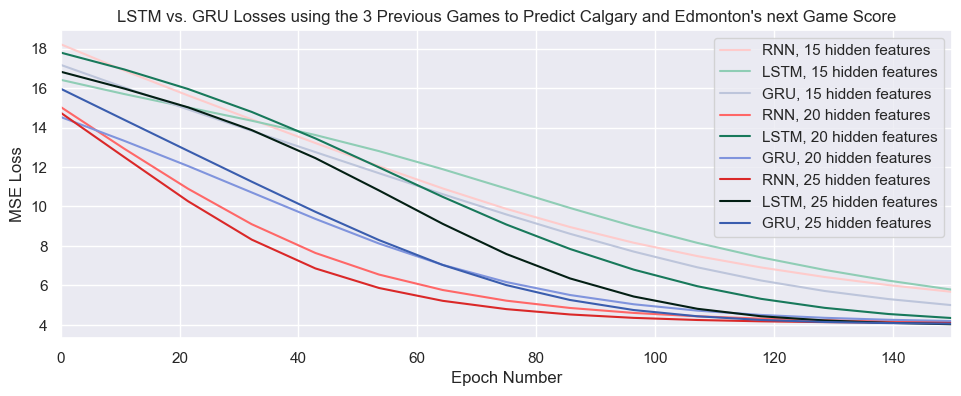

In [147]:
# Plotting Training Losses Across Different Number of Layers and Hidden Features for the RNN vs. LSTM vs. GRU models
graph_epochs = np.linspace(0, total_epochs, (total_epochs//10), endpoint=True)
purple_shades = ["#bdc5db", "#8094dd", "#3a5dae"]
green_shades = ["#8fcdb5", "#18795b", "#031f14"]
warm_shades = ["#fecbcb", "#ff6767", "#da2828"]

fig_RNN_losses, ax_RNN_losses = plt.subplots(1)
ax_RNN_losses.set_title("LSTM vs. GRU Losses using the 3 Previous Games to Predict Calgary and Edmonton's next Game Score")
for ii in range(0, len(hidden_sizes)):
    ax_RNN_losses.plot(graph_epochs, all_SL_MtO_losses[ii], color=warm_shades[ii], label=f'RNN, {hidden_sizes[ii]} hidden features')
    ax_RNN_losses.plot(graph_epochs, LSTM_SL_MtO_losses[ii], color=green_shades[ii], label=f'LSTM, {hidden_sizes[ii]} hidden features')
    ax_RNN_losses.plot(graph_epochs, GRU_SL_MtO_losses[ii], color=purple_shades[ii], label=f'GRU, {hidden_sizes[ii]} hidden features')
ax_RNN_losses.set_ylabel('MSE Loss')
ax_RNN_losses.set_xlabel('Epoch Number')
ax_RNN_losses.set_xlim(0, graph_epochs.max())
ax_RNN_losses.legend()
plt.show()

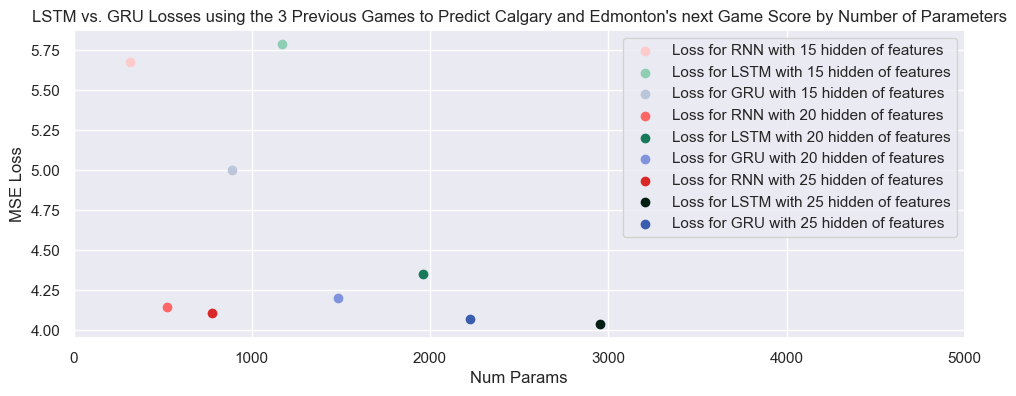

In [148]:
# Plotting the final training loss by the number of parameters for the RNN vs. LSTM vs. GRU models by number of parameters
fig_RNN_losses_params, ax_RNN_losses_params = plt.subplots(1)
ax_RNN_losses_params.set_title("LSTM vs. GRU Losses using the 3 Previous Games to Predict Calgary and Edmonton's next Game Score by Number of Parameters")
for ii in range(0, len(hidden_sizes)):
    ax_RNN_losses_params.scatter(SL_MtO_num_params[ii], all_SL_MtO_losses[ii][-1], color=warm_shades[ii], label=f'Loss for RNN with {hidden_sizes[ii]} hidden of features')
    ax_RNN_losses_params.scatter(LSTM_SL_MtO_num_params[ii], LSTM_SL_MtO_losses[ii][-1], color=green_shades[ii], label=f'Loss for LSTM with {hidden_sizes[ii]} hidden of features')
    ax_RNN_losses_params.scatter(GRU_SL_MtO_num_params[ii], GRU_SL_MtO_losses[ii][-1], color=purple_shades[ii], label=f'Loss for GRU with {hidden_sizes[ii]} hidden of features')
ax_RNN_losses_params.set_ylabel('MSE Loss')
ax_RNN_losses_params.set_xlabel('Num Params')
ax_RNN_losses_params.legend()
ax_RNN_losses_params.set_xlim(0, 5000)
plt.show()

And if we want to predict next Saturday March 29th 2025's Score using the GRU Model...

In [ ]:
# Model Predictions
RNN_SL_MtO_model.load_state_dict(torch.load("NextHockeyGame_RNN.pt"))
RNN_SL_MtO_model.eval()

LSTM_SL_MtO_model.load_state_dict(torch.load("NextHockeyGame_LSTM.pt"))
LSTM_SL_MtO_model.eval()

GRU_SL_MtO_model.load_state_dict(torch.load("NextHockeyGame_GRU.pt"))
GRU_SL_MtO_model.eval()

with torch.no_grad():
    test_scores = torch.from_numpy(test_scores).float()
    predictedScore_RNN = RNN_SL_MtO_model(test_scores)
    predictedScore_LSTM = LSTM_SL_MtO_model(test_scores)
    predictedScore_GRU = GRU_SL_MtO_model(test_scores)

predictedScore_RNN = torch.Tensor.numpy(predictedScore_RNN)
predictedScore_LSTM = torch.Tensor.numpy(predictedScore_LSTM)
predictedScore_GRU = torch.Tensor.numpy(predictedScore_GRU)

print(f"Next Game's Score, Saturday March 29th 2025, will be")
print(f'According to RNN -> Calgary: {round(predictedScore_RNN[0][0])} to Edmonton: {round(predictedScore_RNN[0][1])}')
print(f'According to LSTM -> Calgary: {round(predictedScore_LSTM[0][0])} to Edmonton: {round(predictedScore_LSTM[0][1])}')
print(f'According to GRU -> Calgary: {round(predictedScore_GRU[0][0])} to Edmonton: {round(predictedScore_GRU[0][1])}')

Next Game's Score, Saturday March 29th 2025, will be
According to RNN -> Calgary: 3 to Edmonton: 4
According to LSTM -> Calgary: 3 to Edmonton: 4
According to GRU -> Calgary: 3 to Edmonton: 4


<details>
  <summary>Based on the above examples, how do the number of hidden features, number of layers, model type and number of parameters influence performance?</summary>

  - Hidden Features: an increase in the number of hidden features typically improves performance
  - Number of Layers: an increase in the number of layers typically improves performance
  - Model Type: with the short sequences used in these examples, the LSTM and GRU perform similarly and can at times outperform the simple RNN
  - Number of Parameters: an increase in the number of parameters typically improves performance 
</details>

<details>
  <summary>What could we do to increase performance?</summary>

  - Use a mix of predictive features (such as date AND previous scores)
  - Increase the number of layers and trainable parameters (within reason to prevent overfitting)
  - Increase the number of examples
</details>

<details>
  <summary>How does the activation function affect the model's performance?</summary>

  - PyTorch prebuilt RNN layer only allows Tanh or ReLu to mitigate the vanishing gradient
  - The above examples use Tanh, when tested with ReLu it resulted in some models to not learn
  - If you are wanting a different activation, you could always look into Keras/TF alternative and see if it is more flexible or 
    build your layer from the ground up excluding the activation
  - Are there other activations that may help improve performance of the above models?
</details>

Additional Resources:
- [PyTorch RNN Documentation](https://jaketae.github.io/study/pytorch-rnn/)
- [PyTorch RNN from Scratch](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- [Kaggle RNN](https://www.kaggle.com/code/fanbyprinciple/learning-pytorch-3-coding-an-rnn-gru-lstm)
- [Image-based RNN Example](https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/)